In [1]:
from typing import List

import numpy as np
import pandas as pd
import torch

from gpt_model import *

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap.umap_ as umap

In [2]:
# Variables

from config import KEY, PERIOD, TRANS_TYPE, STORE_PATH, SEQ_TYPE, NORM_SIZE, TARGET_PERIOD

In [3]:

# Build fp
fields = [KEY, SEQ_TYPE]
DATA_FP = "_".join(fields)+".np"
VAL_DATA_FP = "_".join(fields+["val"])+".np"
fields = [KEY, SEQ_TYPE, f"period{PERIOD}", f"pred{TARGET_PERIOD}"]
if TRANS_TYPE == "norm":
    fields += ["norm", f"normsize{NORM_SIZE}"]
elif TRANS_TYPE:
    fields += [TRANS_TYPE]
MODEL_FP = "_".join(fields)+".pt"
fp = os.path.join(STORE_PATH, DATA_FP)
val_fp = os.path.join(STORE_PATH, VAL_DATA_FP)
model_fp = os.path.join(STORE_PATH, MODEL_FP)
model_fp

'C:/Users/robert.franklin/Desktop/local_projects/random/stock-gpt/data/close_single_long_period30_pred1_norm_normsize30.pt'

In [4]:
# Import the data
data = np.load(fp)
val_data = np.load(val_fp)
# Replace nan
train_data = np.where(np.isnan(data), -1, data)
val_data = np.where(np.isnan(val_data), -1, val_data)
# Convert to tensor
train_data = torch.tensor(train_data, dtype=torch.float32)
val_data = torch.tensor(val_data, dtype=torch.float32)
print(f"train and val data shape: {train_data.shape[0]:,.0f} and {val_data.shape[0]:,.0f}")

train and val data shape: 746 and 746


In [5]:
# Transformation methods
def trans_norm(t: torch.Tensor, norm_size:int = NORM_SIZE) -> torch.Tensor:
    # Limit the normalisation group to block_size
    # This will allow for values >1 and <0 in the block
    lim = norm_size if t.shape[1] > norm_size else None
    t_lim = t[:, :lim]
    maxs = (torch.max(
        torch.where(~t_lim.isnan(), t_lim, -torch.inf),
        axis=1
    ).values * torch.ones_like(t.T)).T
    mins = (torch.min(
        torch.where(~t_lim.isnan(), t_lim, torch.inf),
        axis=1
    ).values * torch.ones_like(t.T)).T
    out = ((t - mins) / (maxs - mins))
    # Avoid inf 
    # (this will happen where it's the same number throughout)
    out = torch.where(
        out != torch.inf,
        out, 0
    )
    # Set a max and min limit
    if VAL_LIMIT is not None:
        out = torch.where(out > VAL_LIMIT, VAL_LIMIT, out)
        out = torch.where(out < -VAL_LIMIT, -VAL_LIMIT, out)
    # Convert inf to torch.nan
    out = out.nan_to_num(VAL_LIMIT, neginf=VAL_LIMIT, posinf=VAL_LIMIT)
    return out

def trans_norm_to_first(t: torch.Tensor) -> torch.Tensor:
    t2 = t[:, 0]
    t2 = (t2 * torch.ones_like(t.T)).T
    t = t / t2
    return t

def trans_log(t: torch.Tensor) -> torch.Tensor:
    return torch.log(t.nan_to_num(0, neginf=0, posinf=0))

def trans_inf(t: torch.Tensor) -> torch.Tensor:
    return t.nan_to_num(0, neginf=-1, posinf=1)

# Set the function
if TRANS_TYPE == "norm":
    trans_func = trans_norm
elif TRANS_TYPE == "norm_to_first":
    trans_func = trans_norm_to_first
elif TRANS_TYPE == "log":
    trans_func = trans_log
else:
    trans_func = trans_inf

In [6]:
# data loading
def generate_samples(data: torch.Tensor,
                     batch_size:int,
                     block_size:int,
                     steps:int,
                     ) -> List[torch.Tensor]:
    samples = torch.Tensor()
    n = 0
    while samples.shape[0] < batch_size:
        sample_size = batch_size - samples.shape[0]
        ix1 = torch.randint(data.shape[0], (sample_size, ))
        ix2 = torch.randint(data.shape[1] - (block_size+steps), (sample_size, ))
        ix = torch.stack([ix1, ix2], dim=1)
        new_samples = torch.stack([data[i, j:j+block_size+steps] for i, j in ix])
        # Keep only where it is not full of nan or the same values
        new_samples = new_samples[
            ~torch.isnan(new_samples).all(axis=1)
            & (new_samples.max(axis=1).values != new_samples.min(axis=1).values)
            ]
        samples = torch.cat([samples, new_samples])
        n += 1
        if n > 100:
            raise Exception("Could not find enough samples")
    return samples

def get_batch(
        split,
        step: int = 1,
        trans_func: callable = lambda x: x,
        *args,
        **kwargs
        ) -> List[torch.Tensor]:
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    batch = generate_samples(data, batch_size, PERIOD, step)
    # Normalise
    batch = trans_func(batch, *args , **kwargs)
    # Split into x and y
    x = batch[:, :block_size]
    y = batch[:, step:block_size+step]
    if device == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(
            device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [7]:
# Load the model
model = torch.load(model_fp)

In [8]:
# Extract the item embeddings format he model
pos_embd = torch.Tensor.cpu(model.transformer.wpe.weight.data) # gpt
pos_embd.shape

torch.Size([30, 256])

In [9]:
# Fit umap
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(pos_embd)
# Plot
data = pd.DataFrame(proj_2d, columns=['x', 'y'])
data.index.name = "pos"
data = data.reset_index()

fig = px.scatter(
    data, x='x', y='y',
    hover_data=['pos'],
    color="pos",
    width=600, height=400
)
fig.show()

In [10]:
X, Y = get_batch("val", TARGET_PERIOD, trans_func)
logits, loss = model(X, Y)
print("X", X[0], X.shape)
print("Y", Y[0], Y.shape)
print("logits", logits[0], logits.shape)
print("loss", loss)

X tensor([0.7858, 0.8081, 0.8393, 0.3506, 0.4660, 0.1016, 0.0000, 0.1330, 0.3212,
        0.5025, 0.4488, 0.5490, 0.6686, 0.8181, 0.7470, 0.6551, 0.4363, 0.4392,
        0.8113, 1.0000, 0.8698, 0.8079, 0.7490, 0.9360, 0.8147, 0.7083, 0.8161,
        0.5914, 0.7303, 0.3463], device='cuda:0') torch.Size([128, 30])
Y tensor([ 0.8081,  0.8393,  0.3506,  0.4660,  0.1016,  0.0000,  0.1330,  0.3212,
         0.5025,  0.4488,  0.5490,  0.6686,  0.8181,  0.7470,  0.6551,  0.4363,
         0.4392,  0.8113,  1.0000,  0.8698,  0.8079,  0.7490,  0.9360,  0.8147,
         0.7083,  0.8161,  0.5914,  0.7303,  0.3463, -0.0458], device='cuda:0') torch.Size([128, 30])
logits tensor([0.9354, 0.9349, 0.9350, 0.9475, 0.8457, 0.8437, 0.8053, 0.5543, 0.6400,
        0.6396, 0.6070, 0.5691, 0.5422, 0.5161, 0.3568, 0.3622, 0.2670, 0.2646,
        0.0751, 0.2329, 0.2646, 0.3160, 0.2656, 0.2287, 0.2109, 0.2887, 0.2593,
        0.2280, 0.2884, 0.3403], device='cuda:0', grad_fn=<SelectBackward0>) torch.Size([128, 3

In [11]:
# # X, Y = get_batch("val", TARGET_PERIOD, trans_func)
# X_ = torch.concat([X[:, 15:], torch.zeros_like(X[:, 15:])], dim=1)
# Y_ = torch.concat([Y[:, 15:], torch.zeros_like(Y[:, 15:])], dim=1)
# logits, loss = model(X_, Y_)
# print("X", X_[0], X_.shape)
# print("Y", Y_[0], Y_.shape)
# print("logits", logits[0], logits.shape)
# print("loss", loss)

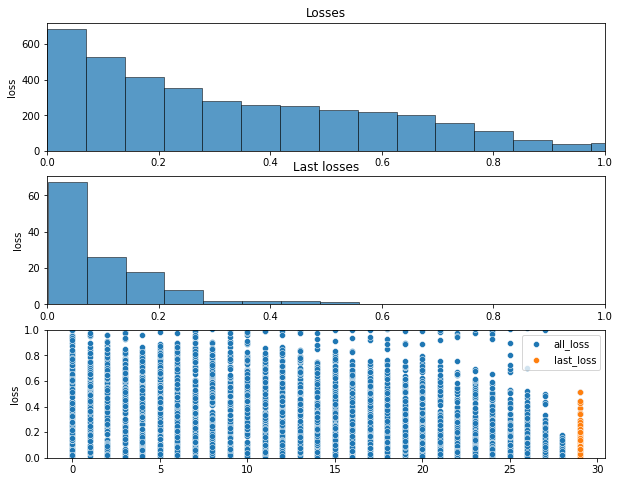

In [12]:
# Plot losses
losses = torch.abs(logits - Y)
last_losses = torch.abs(logits[:, -1] - Y[:, -1])
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 8))
# Hist plot
sns.histplot(x=losses.flatten().detach().cpu().numpy(), bins=100, ax=ax1, label='all_loss')
sns.histplot(x=last_losses.flatten().detach().cpu().numpy(), bins=100, ax=ax2, label='last_loss')
ax1.set_ylabel('loss')
ax2.set_ylabel('loss')
ax1.set_title('Losses')
ax2.set_title('Last losses')
ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)

# Scatter plot
x_ = np.tile(np.arange(X.shape[1]), X.shape[0])
sns.scatterplot(x=x_, y=losses.flatten().detach().cpu().numpy(), ax=ax3, label='all_loss')
x_last_ = np.ones((128)) * PERIOD-1
sns.scatterplot(x=x_last_, y=last_losses.flatten().detach().cpu().numpy(), ax=ax3, label='last_loss')
ax3.set_ylabel('loss')
ax3.set_ylim(0, 1)

plt.show()

<AxesSubplot: >

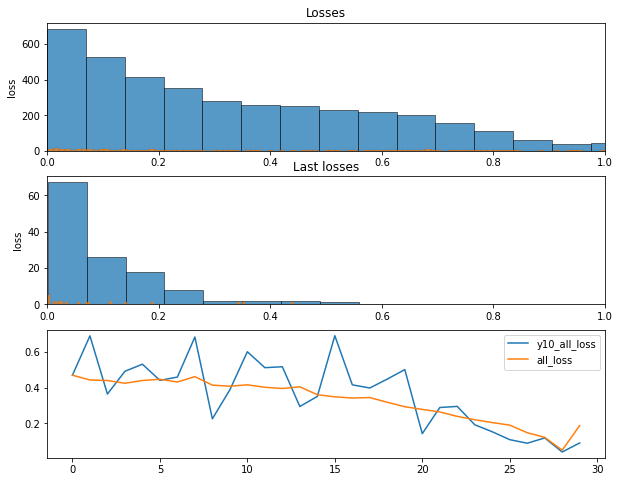

In [13]:
# Calc values for y=1
# y10_mask = Y == 1
y10_mask = torch.isin(
    torch.concat([torch.zeros_like(Y[:, [0]]), Y[:, :-1]], dim=1)
    ,torch.tensor([0, 1], device=device)
)
y10_losses = torch.abs(logits - Y)
y10_losses = y10_losses * y10_mask.to(dtype=torch.float)
y10_losses[~y10_mask] = torch.nan

y_last10_mask = torch.isin(Y[:, -2], torch.tensor([0, 1], device=device))
y_last10_losses = torch.abs(logits[:, -1] - Y[:, -1])
y_last10_losses = y_last10_losses * y_last10_mask.to(dtype=torch.float)
y_last10_losses[~y_last10_mask] = torch.nan

# Plot losses
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 8))
# Hist plot
sns.histplot(x=losses.flatten().detach().cpu().numpy(), bins=100, ax=ax1, label='all_loss')
sns.histplot(x=y10_losses.flatten().detach().cpu().numpy(), bins=100, ax=ax1, label='y10_all_loss')
sns.histplot(x=last_losses.flatten().detach().cpu().numpy(), bins=100, ax=ax2, label='last_loss')
sns.histplot(x=y_last10_losses.flatten().detach().cpu().numpy(), bins=100, ax=ax2, label='y10_last_loss')
ax1.set_ylabel('loss')
ax2.set_ylabel('loss')
ax1.set_title('Losses')
ax2.set_title('Last losses')
ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)

# Scatter plot
# x1_ = np.tile(np.arange(X.shape[1]), X.shape[0])[y10_mask.flatten().detach().cpu().numpy()]
# sns.scatterplot(x=x_, y=losses.detach().cpu().numpy(), ax=ax3, label='all_loss')
# sns.scatterplot(x=x1_, y=y10_losses.flatten().detach().cpu().numpy(), ax=ax3, label='y10_all_loss')
# x_last10_ = (np.ones((128)) * PERIOD-1)[y_last10_mask.flatten().detach().cpu().numpy()]
# sns.scatterplot(x=x_last_, y=last_losses.detach().cpu().numpy(), ax=ax3, label='last_loss')
# sns.scatterplot(x=x_last10_, y=y_last10_losses.flatten().detach().cpu().numpy(), ax=ax3, label='y10_last_loss')
# ax3.set_ylabel('loss')
# ax3.set_ylim(0, 1)

# Line plot
sns.lineplot(x=np.arange(PERIOD), y=y10_losses.nanmean(dim=0).detach().cpu().numpy(), ax=ax3, label='y10_all_loss')
sns.lineplot(x=np.arange(PERIOD), y=losses.nanmean(dim=0).detach().cpu().numpy(), ax=ax3, label='all_loss')

# plt.show()

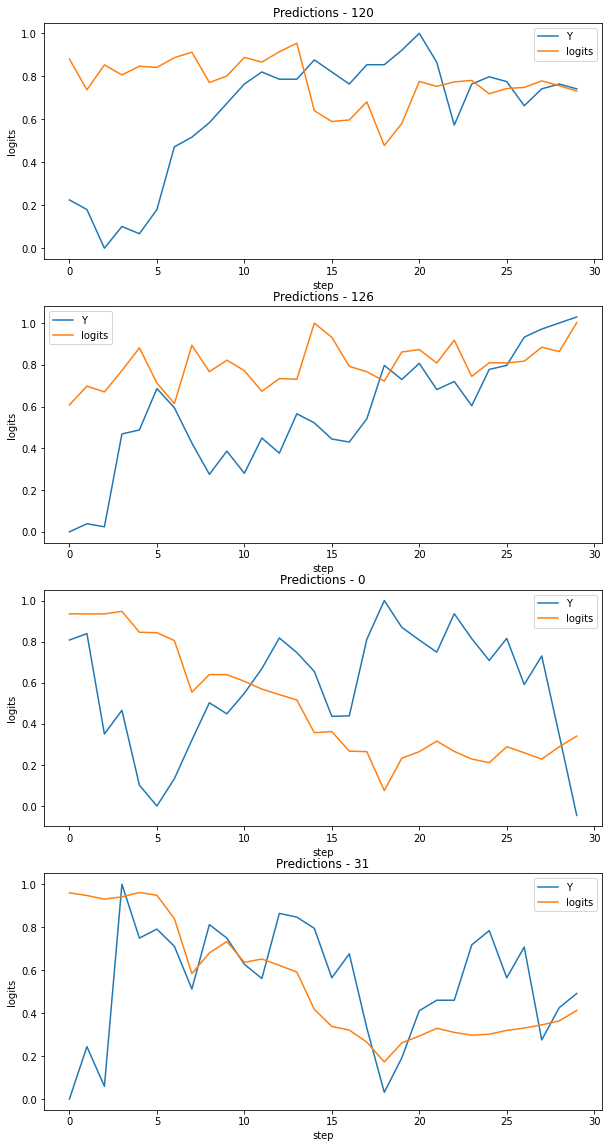

In [18]:
# Plot example predictions
idx = np.random.randint(0, 127, (4))
fig, axs = plt.subplots(nrows=4, figsize=(10, 20))
for ax, i in zip(axs, idx):
    sns.lineplot(x=np.arange(Y.shape[1]), y=Y[i].detach().cpu().numpy(), ax=ax, label='Y')
    sns.lineplot(x=np.arange(Y.shape[1]), y=logits[i].detach().cpu().numpy(), ax=ax, label='logits')
    ax.set_xlabel('step')
    ax.set_ylabel('logits')
    ax.set_title(f'Predictions - {i}')
plt.show()